# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Porto Seguro’s Safe Driver Prediction - Kaggle</p>

## Predict if a driver will file an insurance claim next year

<img src='./img/dont-be-that-guy-safe-driving-tips-for-all-ages-730x432.jpeg' style='height:400px; border-radius: 5px;'/>

---
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">Contents:</p>

* [1. Introduction](#1)
    * [1.1 Libraries](#1.1)
    * [1.2 Loading Dataset](#1.2)
* [2. Data Cleaning & Wrangling](#2)
    * [2.1 Handle Missings](#2.1)
    * [2.2 Data Transformation / Aggregation](#2.2)
* [4. Feature Engineering](#4)
    * [4.2 SMOTE](#4.1)
    * [4.2 PCA](#4.2)
    * [4.3 Cross-validation](#4.3)
    * [4.4 Feature Selection](#4.4)
* [5. Models](#5)
    * [5.1 Lightgbm](#5.1)
    * [5.2 Neural Networks](#5.2)
* [6. Evaluation](#6)
* [7. Kaggle Submission](#7)

<a id="1"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">1- Introduction</p>

<img title="Porto Seguro" src="img/porto-seguro-logo-1.png" alt="Porto Seguro" style='height:100px; padding-left: 15px;' align="right"> In this [competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/), you will predict the probability that an auto insurance policy holder files a claim.

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., `ind`, `reg`, `car`, `calc`). In addition, feature names include the postfix `bin` to indicate binary features and `cat` to indicate categorical features. Features without these designations are either continuous or ordinal. Values of `-1` indicate that the feature was missing from the observation. The `target` columns signifies whether or not a claim was filed for that policy holder. 

<a id="1.1"></a>
## Libraries

In [12]:
from platform import python_version
print('Python version used:', python_version())

Python version used: 3.8.5


In [13]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random

%matplotlib inline
matplotlib.style.use("ggplot")

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [14]:
# !pip install -q -U watermark

In [15]:
%reload_ext watermark
%watermark -a "Leandro Pessini" --iversions

Author: Leandro Pessini

numpy     : 1.19.2
matplotlib: 3.3.2
pandas    : 1.1.3
plotly    : 4.14.3
seaborn   : 0.11.1



<a id="1.2"></a>
## Loading Dataset

In [30]:
# Kaggle
#kaggle_path = "../input/porto/train.csv"

In [31]:
# Local
local_path = "./data/"

In [32]:
train_df = pd.read_csv(local_path + "train.csv")

In [33]:
train_df.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [23]:
print('Number of rows are',train_df.shape[0], 'and number of columns are ',train_df.shape[1])

Number of rows are 595212 and number of columns are  59


## Do we have an imbalanced class?

Yes:  21694
No:  573518


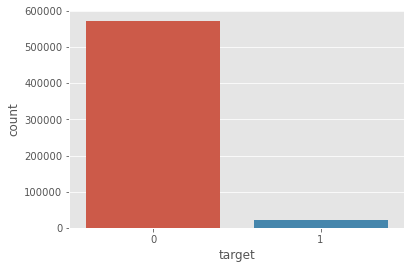

In [26]:
y = train_df.target

ax = sns.countplot(y,label="Count")
N, Y = y.value_counts()
print('Yes: ',Y)
print('No: ',N)

---
We do not have class imbalance problem so no further transformation needed.

<a id="2"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">2- Data Cleaning & Wrangling</p>

In [ ]:
train_df.info()

There are a few variables with a high NULL values and we are setting 

In [ ]:
# Drop columns with >= 80% of NaN values
df_clean = train_df.loc[:, train_df.isnull().mean() < .8]

# For non-Boolean data
# Total number of NaN entries in a column must be less than 80% of total entries:

# df = df.loc[:, df.isnull().sum() < 0.8*df.shape[0]]

In [ ]:
df_clean["ProductName"].unique()
Win8, mse = df_clean["ProductName"].value_counts()
print('win8defender: ',Win8)
print('mse : ',mse)

print('total : ',Win8+mse)

In [ ]:
corr = train_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()

<a id="6"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">6- Evaluation</p>

## Normalized Gini coefficient

$$ 
Gini = 2 * AUC - 1
$$

As for why use this instead of the commonly used AUC, the only reason I can think of is that a random prediction will yield a Gini score of 0 as opposed to the AUC which will be 0.5.

Besides that using the gini coefficient sets the performance of a random classifier to a score of 0... the normalization "improves" the other end of the scale and makes that the score of a perfect classifier is equal to 1 rather than a maximum achievable AUC<1. The improvement being only relative depending on whether you think a more intuitive scale is good or not. Although beyond this easier interpretation you might argue that it (the normalization) also improves generalization and comparison of different data-sets.

__Reference:__

> Hand, D. J., & Till, R. J. (2001). A Simple Generalisation of the Area Under the ROC Curve for Multiple Class Classification Problems. Machine Learning, 45(2), 171–186. https://doi.org/10.1023/a:1010920819831

In [28]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, roc_auc_score

In [29]:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

It turned out that the culprit was how Scikit-Learn scored the hold-out set. By default, it predicts using the predict method on the model rather than the predict_proba method. The output from predict on a classification problem is the class labels while the output from predict_proba is the probabilities for the class labels. For computing the Gini value on the results, the output of predict_proba is more appropriate.

To ensure this happens, we modify the `gini_normalized` function to allow that.

In [40]:
def gini_normalized(y_actual, y_pred):
    """Simple normalized Gini based on Scikit-Learn's roc_auc_score"""
    
    # If the predictions y_pred are binary class probabilities
    if y_pred.ndim == 2:
        if y_pred.shape[1] == 2:
            y_pred = y_pred[:, 1]
    gini = lambda a, p: 2 * roc_auc_score(a, p) - 1
    return gini(y_actual, y_pred) / gini(y_actual, y_actual)

<a id="7"></a>
# <p style="background-color:#018cb7; font-size:100%; text-align:left; color:#FFFFFF; padding: 15px 5px 15px 25px; border-radius: 15px;">7- Kaggle Submission</p>